In [1]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
import requests
import os
import tarfile

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import rand_score, confusion_matrix, adjusted_rand_score, adjusted_mutual_info_score, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from sklearn.manifold import TSNE

from sklearn.cluster import KMeans, AgglomerativeClustering, HDBSCAN
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
import umap 

from utils import *
import itertools

%load_ext autoreload
%autoreload 2

# ECE 219 Project 2: Data Representations and Clustering

## Part 2 - Deep Learning and Clustering of Image Data

In [2]:
# Loading in Flowers Dataset
filename = './flowers_features_and_labels.npz'
mps = torch.device('mps')

if os.path.exists(filename):
    file = np.load(filename)
    f_all, y_all = file['f_all'], file['y_all']

else:
    if not os.path.exists('./flower_photos'):
        # download the flowers dataset and extract its images
        url = 'http://download.tensorflow.org/example_images/flower_photos.tgz'
        with open('./flower_photos.tgz', 'wb') as file:
            file.write(requests.get(url).content)
        with tarfile.open('./flower_photos.tgz') as file:
            file.extractall('./')
        os.remove('./flower_photos.tgz')

    class FeatureExtractor(nn.Module):
        def __init__(self):
            super().__init__()

            vgg = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16', pretrained=True)

            # Extract VGG-16 Feature Layers
            self.features = list(vgg.features)
            self.features = nn.Sequential(*self.features)
            # Extract VGG-16 Average Pooling Layer
            self.pooling = vgg.avgpool
            # Convert the image into one-dimensional vector
            self.flatten = nn.Flatten()
            # Extract the first part of fully-connected layer from VGG16
            self.fc = vgg.classifier[0]

        def forward(self, x):
            # It will take the input 'x' until it returns the feature vector called 'out'
            out = self.features(x)
            out = self.pooling(out)
            out = self.flatten(out)
            out = self.fc(out) 
            return out 

    # Initialize the model
    assert torch.backends.mps.is_available() # Use MPS instead of CUDA
    feature_extractor = FeatureExtractor().to(mps).eval()

    dataset = datasets.ImageFolder(root='./flower_photos',
                                   transform=transforms.Compose([transforms.Resize(224),
                                                                 transforms.CenterCrop(224),
                                                                 transforms.ToTensor(),
                                                                 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]))
    dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

    # Extract features and store them on disk
    f_all, y_all = np.zeros((0, 4096)), np.zeros((0,))
    for x, y in tqdm(dataloader):
        with torch.no_grad():
            f_all = np.vstack([f_all, feature_extractor(x.to(mps)).cpu()])
            y_all = np.concatenate([y_all, y])
    np.savez(filename, f_all=f_all, y_all=y_all)



In [3]:
print(f_all.shape, y_all.shape)
num_features = f_all.shape[1]

(3670, 4096) (3670,)


**Question 19**  
Although the VCG is trainined on a completely different dataset (i.e. ImageNet, which contains images of various objects), the features extracted from those images are still useful representations. The first part of an image model is typically feature extraction of low-level characteristics of an image, such as edges and textures. These characteristics are typically universal for any image, which makes it useful as a starting point for any fine-tuning for a specific downstream task. It's especially useful since you do not need to train these features from scratch, which can take a substantial amount of time and resources.

**Question 20**  
Based on the code in the `FeatureExtractor` class, the code is converting the raw pixal images (that arer already pre-processed and transformed in the `transform` argument in the `datasetes.ImageFolder`function call) with the same sequential layers/steps outlined in the pre-trained VGG network. We can look at each individual layer and its parameters when we run the line `vgg.features`. The advantage of doing so is that each layer is already pretrained and has already established hidden weights from training on ImageNet. An average pooling layer is then applied to reduce the dimensions of the embeddings into a 7 by 7 matrix, then further reduced to a 1-D vector by `nn.Flatten`. Finally, the 1-D vector goes through a fully-connected layer to produce a vector with 4096 dimensions.

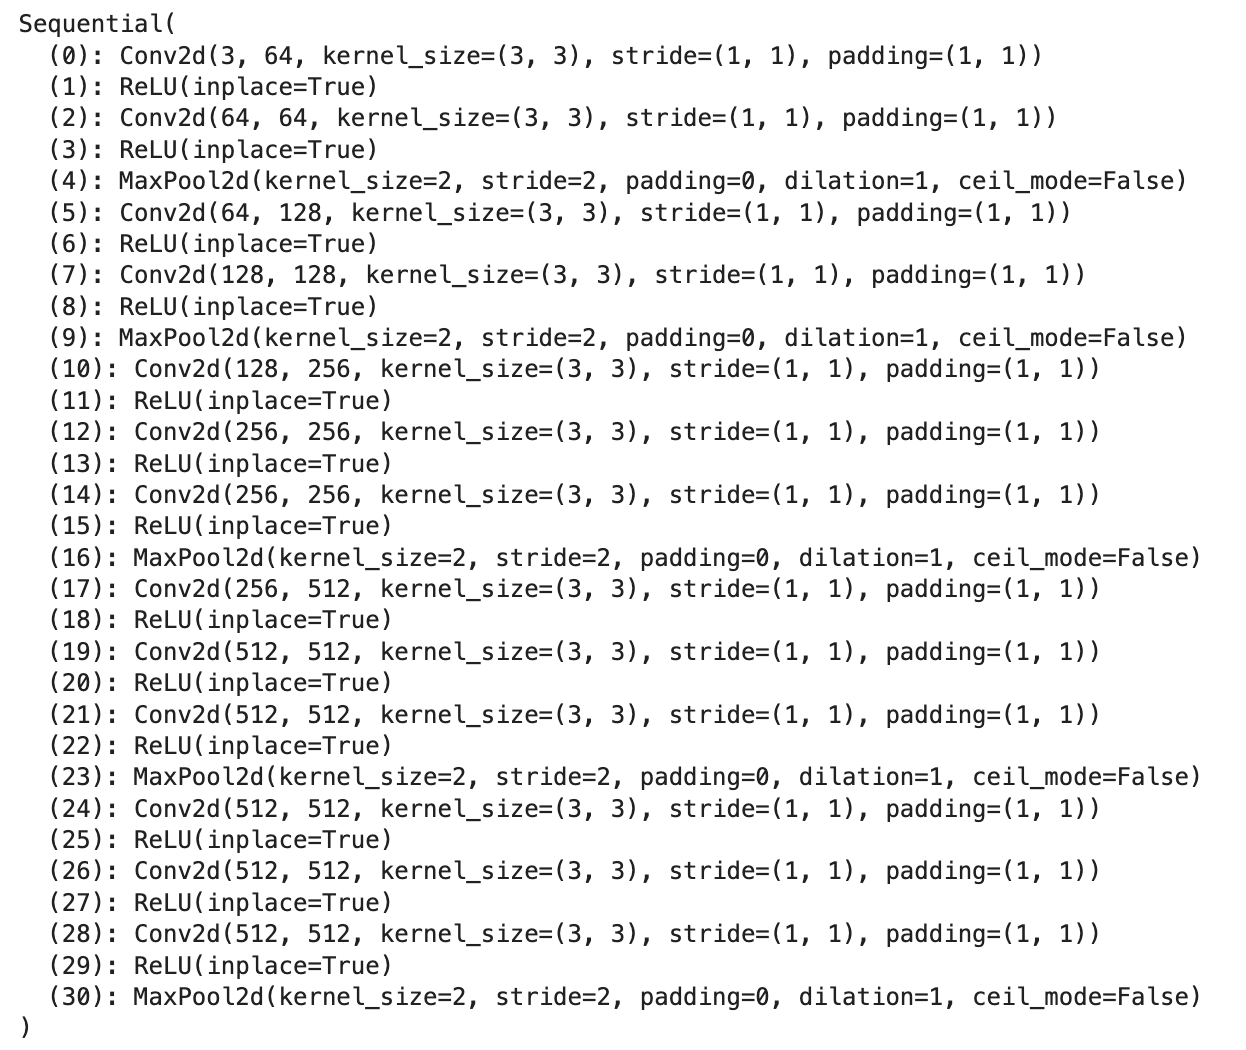

**Question 21**
The original images are of varying lengths, but is transformed into a 224 x 224 x 3 matrix. The processed image is 224 x 224 pixels, and the final dimension (`x 3`) represents the RGB values. The VGG network, at the end, extracts 4096 features for each image.   

**Question 22**
The extracted features are dense features, which means it has very few zero values.

### T-SNE Visualization

In [5]:
tsne_reduced = TSNE(n_components=2).fit_transform(f_all)

In [8]:
y_all

array([4., 1., 3., ..., 2., 0., 4.])

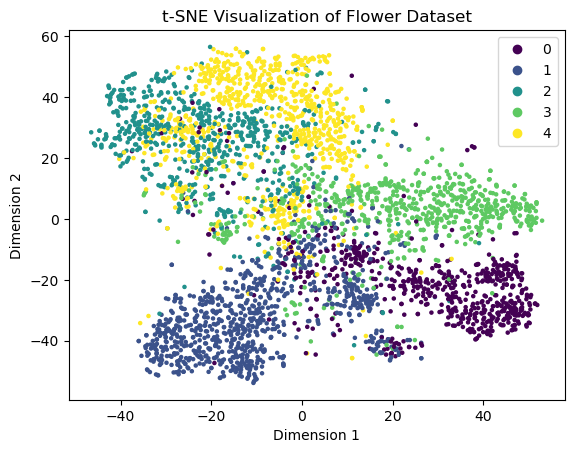

In [19]:
# Create custom legend

scatter = plt.scatter(
    tsne_reduced[:, 0], 
    tsne_reduced[:, 1], 
    c=[int(x) for x in y_all],
    s=5
)
plt.title('t-SNE Visualization of Flower Dataset', fontsize=12)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

# Create labels for legend
unique_labels = np.unique(y_all)
legend_labels = [f'Class {label}' for label in unique_labels]

# Add legend
plt.legend(*scatter.legend_elements())
plt.show()

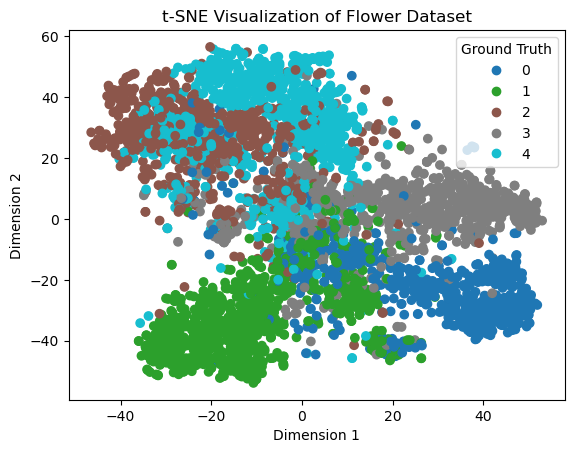

In [12]:
# Plot results
scatter = plt.scatter(tsne_reduced[:, 0], tsne_reduced[:, 1], c = y_all, cmap = 'tab10')
plt.title('t-SNE Visualization of Flower Dataset')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

# Create labels for legend
unique_labels = np.unique(y_all)
legend_labels = [f'Class {label}' for label in unique_labels]

# Add legend
plt.legend(*scatter.legend_elements(), title = "Ground Truth", loc = "best")

# Show plot
plt.show()

## Hyperparameter Tuning for Dim. Reduction and Clustering Models

In [5]:
hdbscan_params = {
    'min_cluster_size': [2, 5, 10],
    'min_samples': [2, 5, 10]
}
eval_df = pd.DataFrame(columns=['DM Model', 'DM Model Params', 'Clustering Model', 'Clustering Model Params', 'Rand Score'])

In [8]:
# No Dim Reduction --------------------------
print('> No Dimensionality Reduction')
dm_name = 'None'
dm_params = 'None'
reduced = f_all

# KMeans Clustering
kmeans_labels = KMeans(n_clusters=5).fit_predict(reduced)
eval_metrics = evaluate_cluster_model(y_all, kmeans_labels)[['Rand Score']]
eval_metrics['DM Model'] = 'None'
eval_metrics['DM Model Params'] = 'None'
eval_metrics['Clustering Model'] = 'KMeans'
eval_metrics['Clustering Model Params'] = str({'n_clusters': 5})
eval_df = pd.concat([eval_df, eval_metrics])


# Agglomerative Clustering
agg_clust_labels = AgglomerativeClustering(n_clusters=5).fit_predict(reduced)
eval_metrics = evaluate_cluster_model(y_all, agg_clust_labels)[['Rand Score']]
eval_metrics['DM Model'] = 'None'
eval_metrics['DM Model Params'] = 'None'
eval_metrics['Clustering Model'] = 'Agglomerative'
eval_metrics['Clustering Model Params'] = str({'n_clusters': 5})
eval_df = pd.concat([eval_df, eval_metrics])

# HDBSCAN Clustering
for hdbscan_args in (dict(zip(hdbscan_params, x)) for x in itertools.product(*hdbscan_params.values())):
    print(hdbscan_args)
    hdbscsan_labels = HDBSCAN(**hdbscan_args).fit_predict(reduced)
    eval_metrics = evaluate_cluster_model(y_all, hdbscsan_labels)[['Rand Score']]
    eval_metrics['DM Model'] = 'None'
    eval_metrics['DM Model Params'] = 'None'
    eval_metrics['Clustering Model'] = 'HDBSCAN'
    eval_metrics['Clustering Model Params'] = str(hdbscan_args)
    eval_df = pd.concat([eval_df, eval_metrics])

# SVD Reduction --------------------------
print('> TruncatedSVD Dimensionality Reduction')
dm_name = 'SVD'
dm_params = {'n_components': 50}
reduced = TruncatedSVD(n_components=50).fit_transform(f_all)

# KMeans Clustering
kmeans_labels = KMeans(n_clusters=5).fit_predict(reduced)
eval_metrics = evaluate_cluster_model(y_all, kmeans_labels)[['Rand Score']]
eval_metrics['DM Model'] = dm_name
eval_metrics['DM Model Params'] = str(dm_params)
eval_metrics['Clustering Model'] = 'KMeans'
eval_metrics['Clustering Model Params'] = str({'n_clusters': 5})
eval_df = pd.concat([eval_df, eval_metrics])


# Agglomerative Clustering
agg_clust_labels = AgglomerativeClustering(n_clusters=5).fit_predict(reduced)
eval_metrics = evaluate_cluster_model(y_all, agg_clust_labels)[['Rand Score']]
eval_metrics['DM Model'] = dm_name
eval_metrics['DM Model Params'] = str(dm_params)
eval_metrics['Clustering Model'] = 'Agglomerative'
eval_metrics['Clustering Model Params'] = str({'n_clusters': 5})
eval_df = pd.concat([eval_df, eval_metrics])

# HDBSCAN Clustering
for hdbscan_args in (dict(zip(hdbscan_params, x)) for x in itertools.product(*hdbscan_params.values())):
    print(hdbscan_args)
    hdbscsan_labels = HDBSCAN(**hdbscan_args).fit_predict(reduced)
    eval_metrics = evaluate_cluster_model(y_all, hdbscsan_labels)[['Rand Score']]
    eval_metrics['DM Model'] = dm_name
    eval_metrics['DM Model Params'] = str(dm_params)
    eval_metrics['Clustering Model'] = 'HDBSCAN'
    eval_metrics['Clustering Model Params'] = str(hdbscan_args)
    eval_df = pd.concat([eval_df, eval_metrics])

# UMAP Reduction --------------------------
print('> UMAP Dimensionality Reduction')
dm_name = 'UMAP'
dm_params = {'n_components': 50}
reduced = umap.UMAP(n_components=50).fit_transform(f_all)

# KMeans Clustering
kmeans_labels = KMeans(n_clusters=5).fit_predict(reduced)
eval_metrics = evaluate_cluster_model(y_all, kmeans_labels)[['Rand Score']]
eval_metrics['DM Model'] = dm_name
eval_metrics['DM Model Params'] = str(dm_params)
eval_metrics['Clustering Model'] = 'KMeans'
eval_metrics['Clustering Model Params'] = str({'n_clusters': 5})
eval_df = pd.concat([eval_df, eval_metrics])


# Agglomerative Clustering
agg_clust_labels = AgglomerativeClustering(n_clusters=5).fit_predict(reduced)
eval_metrics = evaluate_cluster_model(y_all, agg_clust_labels)[['Rand Score']]
eval_metrics['DM Model'] = dm_name
eval_metrics['DM Model Params'] = str(dm_params)
eval_metrics['Clustering Model'] = 'Agglomerative'
eval_metrics['Clustering Model Params'] = str({'n_clusters': 5})
eval_df = pd.concat([eval_df, eval_metrics])

# HDBSCAN Clustering
for hdbscan_args in (dict(zip(hdbscan_params, x)) for x in itertools.product(*hdbscan_params.values())):
    print(hdbscan_args)
    hdbscsan_labels = HDBSCAN(**hdbscan_args).fit_predict(reduced)
    eval_metrics = evaluate_cluster_model(y_all, hdbscsan_labels)[['Rand Score']]
    eval_metrics['DM Model'] = dm_name
    eval_metrics['DM Model Params'] = str(dm_params)
    eval_metrics['Clustering Model'] = 'HDBSCAN'
    eval_metrics['Clustering Model Params'] = str(hdbscan_args)
    eval_df = pd.concat([eval_df, eval_metrics])

# Autoencoder Reduction --------------------------
print('> Autoencoder Dimensionality Reduction')
dm_name = 'Autoencoder'
dm_params = {'n_components': 50}
reduced = Autoencoder(n_components=50).fit_transform(f_all)

# KMeans Clustering
kmeans_labels = KMeans(n_clusters=5).fit_predict(reduced)
eval_metrics = evaluate_cluster_model(y_all, kmeans_labels)[['Rand Score']]
eval_metrics['DM Model'] = dm_name
eval_metrics['DM Model Params'] = str(dm_params)
eval_metrics['Clustering Model'] = 'KMeans'
eval_metrics['Clustering Model Params'] = str({'n_clusters': 5})
eval_df = pd.concat([eval_df, eval_metrics])


# Agglomerative Clustering
agg_clust_labels = AgglomerativeClustering(n_clusters=5).fit_predict(reduced)
eval_metrics = evaluate_cluster_model(y_all, agg_clust_labels)[['Rand Score']]
eval_metrics['DM Model'] = dm_name
eval_metrics['DM Model Params'] = str(dm_params)
eval_metrics['Clustering Model'] = 'Agglomerative'
eval_metrics['Clustering Model Params'] = str({'n_clusters': 5})
eval_df = pd.concat([eval_df, eval_metrics])

# HDBSCAN Clustering
for hdbscan_args in (dict(zip(hdbscan_params, x)) for x in itertools.product(*hdbscan_params.values())):
    hdbscan_labels = HDBSCAN(**hdbscan_args).fit_predict(reduced)
    eval_metrics = evaluate_cluster_model(y_all, hdbscan_labels)[['Rand Score']]
    eval_metrics['DM Model'] = dm_name
    eval_metrics['DM Model Params'] = str(dm_params)
    eval_metrics['Clustering Model'] = 'HDBSCAN'
    eval_metrics['Clustering Model Params'] = str(hdbscan_args)
    eval_df = pd.concat([eval_df, eval_metrics])

eval_df

> TruncatedSVD Dimensionality Reduction
{'min_cluster_size': 2, 'min_samples': 2}
{'min_cluster_size': 2, 'min_samples': 5}
{'min_cluster_size': 2, 'min_samples': 10}
{'min_cluster_size': 5, 'min_samples': 2}
{'min_cluster_size': 5, 'min_samples': 5}
{'min_cluster_size': 5, 'min_samples': 10}
{'min_cluster_size': 10, 'min_samples': 2}
{'min_cluster_size': 10, 'min_samples': 5}
{'min_cluster_size': 10, 'min_samples': 10}
> UMAP Dimensionality Reduction
{'min_cluster_size': 2, 'min_samples': 2}
{'min_cluster_size': 2, 'min_samples': 5}
{'min_cluster_size': 2, 'min_samples': 10}
{'min_cluster_size': 5, 'min_samples': 2}
{'min_cluster_size': 5, 'min_samples': 5}
{'min_cluster_size': 5, 'min_samples': 10}
{'min_cluster_size': 10, 'min_samples': 2}
{'min_cluster_size': 10, 'min_samples': 5}
{'min_cluster_size': 10, 'min_samples': 10}
> Autoencoder Dimensionality Reduction


100%|██████████| 100/100 [00:31<00:00,  3.22it/s]


,DM Model,DM Model Params,Clustering Model,Clustering Model Params,Rand Score
0,None,None,KMeans,{'n_clusters': 5},0.707825
0,None,None,Agglomerative,{'n_clusters': 5},0.686200
0,None,None,HDBSCAN,"{'min_cluster_size': 2, 'min_samples': 2}",0.438554
0,None,None,HDBSCAN,"{'min_cluster_size': 2, 'min_samples': 5}",0.450203
0,None,None,HDBSCAN,"{'min_cluster_size': 2, 'min_samples': 10}",0.414391
0,None,None,HDBSCAN,"{'min_cluster_size': 5, 'min_samples': 2}",0.417910
0,None,None,HDBSCAN,"{'min_cluster_size': 5, 'min_samples': 5}",0.378503
0,None,None,HDBSCAN,"{'min_cluster_size': 5, 'min_samples': 10}",0.203584
0,None,None,HDBSCAN,"{'min_cluster_size': 10, 'min_samples': 2}",0.417584
0,None,None,HDBSCAN,"{'min_cluster_size': 10, 'min_samples': 5}",0.203584


In [9]:
eval_df.sort_values('Rand Score', ascending=False)

,DM Model,DM Model Params,Clustering Model,Clustering Model Params,Rand Score
0,UMAP,{'n_components': 50},KMeans,{'n_clusters': 5},0.792540
0,UMAP,{'n_components': 50},Agglomerative,{'n_clusters': 5},0.782848
0,UMAP,{'n_components': 50},HDBSCAN,"{'min_cluster_size': 2, 'min_samples': 2}",0.771898
0,UMAP,{'n_components': 50},HDBSCAN,"{'min_cluster_size': 10, 'min_samples': 2}",0.754260
0,UMAP,{'n_components': 50},HDBSCAN,"{'min_cluster_size': 5, 'min_samples': 2}",0.745659
0,Autoencoder,{'n_components': 50},Agglomerative,{'n_clusters': 5},0.738079
0,SVD,{'n_components': 50},KMeans,{'n_clusters': 5},0.734709
0,Autoencoder,{'n_components': 50},KMeans,{'n_clusters': 5},0.734298
0,SVD,{'n_components': 50},Agglomerative,{'n_clusters': 5},0.713730
0,UMAP,{'n_components': 50},HDBSCAN,"{'min_cluster_size': 2, 'min_samples': 10}",0.708355


## Comparing Accuracy Between MLP Classifier with and without Dimensionality Reduction

In [55]:
class MLP(torch.nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(num_features, 1280),
            nn.ReLU(True),
            nn.Linear(1280, 640),
            nn.ReLU(True), 
            nn.Linear(640, 5),
            nn.LogSoftmax(dim=1)
        )
        self.to(torch.device('mps'))
    
    
    def forward(self, X):
        return self.model(X)
    
    def train(self, X, y):
        X = torch.tensor(X, dtype=torch.float32, device='mps')
        y = torch.tensor(y, dtype=torch.int64, device='mps')

        self.model.train()
        
        criterion = nn.NLLLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)

        dataset = TensorDataset(X, y)
        dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

        for epoch in tqdm(range(100)):
            epoch_loss = 0.0
            correct = 0
            total = 0
            for (X_, y_) in dataloader:
                optimizer.zero_grad()
                output = self(X_) # Forward pass
                loss = criterion(output, y_)
                loss.backward()
                optimizer.step()

                # Status printing
                epoch_loss += loss.item()
                _, y_pred = output.max(1)
                correct += (y_pred == y_).sum().item()
                total += y_.size(0)

            # Print stats every 25 epochs
            if epoch % 25 == 0:
                avg_loss = epoch_loss / len(dataloader)
                accuracy = correct / total * 100
                print(f"Epoch [{epoch+1}/{100}] - Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")
            
        return self
    
    def eval(self, X_test, y_test):
        X_test = torch.tensor(X_test, dtype=torch.float32, device='mps')
        y_test = torch.tensor(y_test, dtype=torch.float32, device='mps')

        self.model.eval()

        with torch.no_grad():
            y_pred = self(X_test) # Forward pass
            _, y_pred = torch.max(y_pred, 1) # Get indices of max value
            accuracy_score = (y_pred == y_test).sum().item() / X_test.shape[0]
            
        return accuracy_score

In [ ]:
# Split dataset into test and train
X_train, X_test, y_train, y_test = train_test_split(f_all, y_all, test_size=0.2, random_state=42)

### MLP Classification w/o Dim. Reduction

In [59]:
# Initialize MLP Model
mlp_model = MLP(num_features=4096)

# Train Model
mlp_model.train(X_train, y_train)

# Evaluate model
mlp_model.eval(X_test, y_test)

  1%|          | 1/100 [00:00<00:33,  2.95it/s]

Epoch [1/100] - Loss: 1.6505, Accuracy: 64.61%


 26%|██▌       | 26/100 [00:07<00:20,  3.69it/s]

Epoch [26/100] - Loss: 0.0002, Accuracy: 100.00%


 51%|█████     | 51/100 [00:13<00:12,  3.77it/s]

Epoch [51/100] - Loss: 0.0000, Accuracy: 100.00%


 76%|███████▌  | 76/100 [00:20<00:06,  3.82it/s]

Epoch [76/100] - Loss: 0.0000, Accuracy: 100.00%


100%|██████████| 100/100 [00:26<00:00,  3.75it/s]


0.9019073569482289

### MLP Classification w/ Dim. Reduction

In [74]:
reducer_model = Autoencoder(n_components=50).fit(X_train)
X_train_reduced = reducer_model.transform(X_train)
X_test_reduced = reducer_model.transform(X_test)

# Initialize MLP Model
mlp_model = MLP(num_features=50)

# Train Model
mlp_model.train(X_train_reduced, y_train)

# Evaluate model
mlp_model.eval(X_test_reduced, y_test)

  2%|▏         | 2/100 [00:00<00:18,  5.44it/s]

Epoch [1/100] - Loss: 1.6290, Accuracy: 67.57%


 27%|██▋       | 27/100 [00:05<00:14,  5.05it/s]

Epoch [26/100] - Loss: 0.0108, Accuracy: 99.97%


 52%|█████▏    | 52/100 [00:10<00:09,  5.13it/s]

Epoch [51/100] - Loss: 0.0012, Accuracy: 100.00%


 76%|███████▌  | 76/100 [00:15<00:04,  5.29it/s]

Epoch [76/100] - Loss: 0.0005, Accuracy: 100.00%


100%|██████████| 100/100 [00:19<00:00,  5.02it/s]


0.8937329700272479